In [ ]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import  MOGPRegressor_bounded_noises, MORCGP_bounded_noises
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 18,    
    'xtick.labelsize': 22,   
    'ytick.labelsize': 22,  
    'legend.fontsize': 20,
    'lines.linewidth': 5,    
    'lines.markersize': 8   
})

In [ ]:
dfs = pd.read_excel(r'FNCL 28-8 11-09.xlsx', sheet_name=["FNCL 5 9 25", "FNCL 5.5 9 25", "FNCL 6 9 25"])
df_fncl5 = dfs["FNCL 5 9 25"]
df_fncl5_5 = dfs["FNCL 5.5 9 25"]
df_fncl6 = dfs["FNCL 6 9 25"]
df_fncl5

,Date,Last Price
0,2025-09-11 21:56:36,99-26
1,2025-09-11 21:56:36,99-26
2,2025-09-11 21:56:36,99-26
3,2025-09-11 21:56:36,99-26
4,2025-09-11 20:51:44,99-27+
...,...,...
1875,2025-08-28 13:12:02,98-20
1876,2025-08-28 13:02:02,98-19+
1877,2025-08-28 13:02:02,98-19
1878,2025-08-28 13:02:02,98-19+


In [5]:
def preprocess_data(dfs, securities, target_dates):
    df_fncl5 = dfs["FNCL 5 9 25"]
    df_fncl5_5 = dfs["FNCL 5.5 9 25"]
    df_fncl6 = dfs["FNCL 6 9 25"]

    # Only consider last price for same timestamp
    def process_last_price(df):
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by=['Date'])
        result = df.groupby('Date', as_index=False).last()
        return result
    fncl5_last_price = process_last_price(df_fncl5)
    fncl5_5_last_price = process_last_price(df_fncl5_5)
    fncl6_last_price = process_last_price(df_fncl6)

    # Process bloomberg format to numeric
    def parse_bloomberg_price(price) -> float:
        if pd.isna(price):
            return None
        price_str = str(price)
        if "-" not in price_str:
            return float(price_str)
        whole, frac = price_str.split("-")
        whole = int(whole)
        if frac.endswith("+"):
            frac_val = int(frac[:-1]) + 0.5
        else:
            frac_val = int(frac)
        return whole + frac_val / 32.0
    fncl5_last_price["Last Price"] = fncl5_last_price["Last Price"].apply(parse_bloomberg_price)
    fncl5_5_last_price["Last Price"] = fncl5_5_last_price["Last Price"].apply(parse_bloomberg_price)
    fncl6_last_price["Last Price"] = fncl6_last_price["Last Price"].apply(parse_bloomberg_price)

    # Either two or three securities
    if securities == 2:
        def merge_two_prices(df1, df2, col_names=('fncl5', 'fncl5_5')):
            df1_renamed = df1[['Date', 'Last Price']].rename(columns={'Last Price': col_names[0]})
            df2_renamed = df2[['Date', 'Last Price']].rename(columns={'Last Price': col_names[1]})
            merged_df = df1_renamed.merge(df2_renamed, on='Date', how='outer')
            merged_df = merged_df.sort_values('Date').reset_index(drop=True)
            return merged_df
        merged_df = merge_two_prices(fncl5_last_price, fncl5_5_last_price)
    else:
        def merge_price_data(df1, df2, df3, col_names=('fncl5', 'fncl5_5', 'fncl6')):           
            df1_renamed = df1[['Date', 'Last Price']].rename(columns={'Last Price': col_names[0]})
            df2_renamed = df2[['Date', 'Last Price']].rename(columns={'Last Price': col_names[1]})
            df3_renamed = df3[['Date', 'Last Price']].rename(columns={'Last Price': col_names[2]})
            merged_df = df1_renamed.merge(df2_renamed, on='Date', how='outer') \
                                    .merge(df3_renamed, on='Date', how='outer')
            merged_df = merged_df.sort_values('Date').reset_index(drop=True)
            return merged_df
        merged_df = merge_price_data(fncl5_last_price, fncl5_5_last_price, fncl6_last_price)

    # Filter the dataframe for those dates
    df_selected_dates = merged_df[merged_df['Date'].dt.date.isin(target_dates)]

    def convert_date_to_minutes(df, date_col='Date'):
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col])
        df[date_col] = (df[date_col] - df[date_col].iloc[0]).dt.total_seconds() / 60.0
        return df
    df = convert_date_to_minutes(df_selected_dates)

    # X as the Date column
    X = df['Date'].to_numpy().reshape(-1,1)

    if securities == 2:
        Y = df[['fncl5', 'fncl5_5']].to_numpy()
    else:
        Y = df[['fncl5', 'fncl5_5', 'fncl6']].to_numpy()
    return X, Y

target_dates = pd.to_datetime(['2025-09-08', '2025-09-09', '2025-09-10']).date
target_dates = pd.to_datetime(['2025-09-08', '2025-09-09']).date
x, Y = preprocess_data(dfs=dfs, securities=3, target_dates=target_dates)

In [ ]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_std = scaler_X.fit_transform(x)
Y_std = scaler_Y.fit_transform(Y)

In [ ]:
N, D = Y_std.shape

epsilon = 5/N
epsilons = np.array([epsilon]*D)
bounds = ((1/128) / scaler_Y.scale_)**2
Y_train_clean = Y_std[~np.isnan(Y_std).any(axis=1)]
mcd = MinCovDet(support_fraction=1-epsilon*D).fit(Y_train_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)

X_std_test = np.linspace(-1.4, 1.4, 1000).reshape(-1, 1)

# MOGP bounded noise
mogp = MOGPRegressor_bounded_noises(mean=0, length_scale=0.01, noise=bounds, A=robust_init_A)
mogp.fit(X_std, Y_std)
mogp.optimize_hyperparameters(bounds=bounds)
mu_mogp, var_mogp = mogp.predict(X_std_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP bounded noise
morcgp = MORCGP_bounded_noises(mean=0, length_scale=0.01, noise_var=bounds, A=robust_init_A)
morcgp.fit(X_std, Y_std, epsilons)
morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True, bounds=bounds)
mu_morcgp, var_morcgp = morcgp.predict(X_std_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

In [12]:
x_tester = np.linspace(-1.4, 1.4, 2000).reshape(-1, 1)
x_tester_rescaled = scaler_X.inverse_transform(x_tester).reshape(-1,1)

test_mogp, test_mogp_var = mogp.predict(x_tester)
test_mogp_std = np.sqrt(test_mogp_var + mogp.noise)
test_morcgp, test_morcgp_var = morcgp.predict(x_tester)
test_morcgp_std = np.sqrt(test_morcgp_var + morcgp.noise_var)

test_mogp_rescaled = scaler_Y.inverse_transform(test_mogp)
test_mogp_std_rescaled = test_mogp_std * scaler_Y.scale_
test_morcgp_rescaled = scaler_Y.inverse_transform(test_morcgp)
test_morcgp_std_rescaled = test_morcgp_std * scaler_Y.scale_

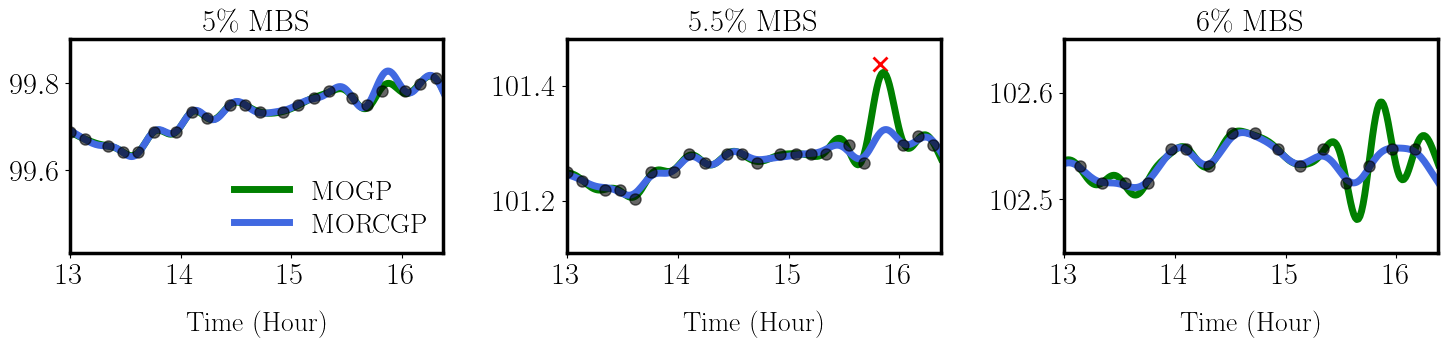

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Flatten x for plotting
x_flat = x.flatten()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Define y-limits for each subplot
y_limits = [
    [99.41, 99.9],     
    [101.11, 101.48],  
    [102.45, 102.65]   
]

# Common x-limit
x_limit = [300, 545]

# Define tick labels and positions (as fraction of x-range)
tick_labels = ['13', '14', '15', '16']
tick_positions_fraction = np.linspace(0, 8/9, len(tick_labels))

# Convert fractional positions to actual x positions
x_start, x_end = x_limit
tick_positions = x_start + tick_positions_fraction * (x_end - x_start)

# Titles for each subplot
titles = [r'5\% MBS', r'5.5\% MBS', r'6\% MBS']

for i in range(3):
    # mask out the special red point for subplot 2
    if i == 1:
        mask = np.arange(len(x_flat)) != 61
        axes[i].plot(x_flat[mask], Y[mask, i], 'o', alpha=0.6, color='black', zorder=10)
        axes[i].plot(x_flat[61], Y[61, i], 'x', color='red', markersize=10, mew=2)
    else:
        axes[i].plot(x_flat, Y[:, i], 'o', alpha=0.6, color='black', zorder=10)
    
    # other lines
    axes[i].plot(x_tester_rescaled, test_mogp_rescaled[:, i], '-', color='Green', linewidth=5)
    axes[i].plot(x_tester_rescaled, test_morcgp_rescaled[:, i], '-', color='RoyalBlue', linewidth=5)
    
    # Only set x-label for middle subplot
    axes[i].set_xlabel('Time (Hour)', fontsize=20, labelpad=15)

    axes[i].set_ylim(y_limits[i])
    axes[i].set_xlim(x_limit)
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(tick_labels)
    axes[i].set_title(titles[i], fontsize=22)

    # Thicker borders
    for spine in axes[i].spines.values():
        spine.set_linewidth(2.5)


# Add custom legend to the leftmost subplot
mogp_line = mlines.Line2D([], [], color='Green', label='MOGP')
morcp_line = mlines.Line2D([], [], color='RoyalBlue', label='MO-RCGP')
axes[0].legend(
    handles=[mogp_line, morcp_line],
    loc='lower right',
    fontsize=20,
    frameon=False,
    handlelength=2,    
    handleheight=1,    
    labelspacing=0.2,  
    borderpad=0.01     
)
axes[1].plot(x_flat[61], Y[61, 1], 'x', color='red')

plt.tight_layout()
plt.show()

fig.savefig("./FNCL.pdf", format='pdf', bbox_inches='tight')

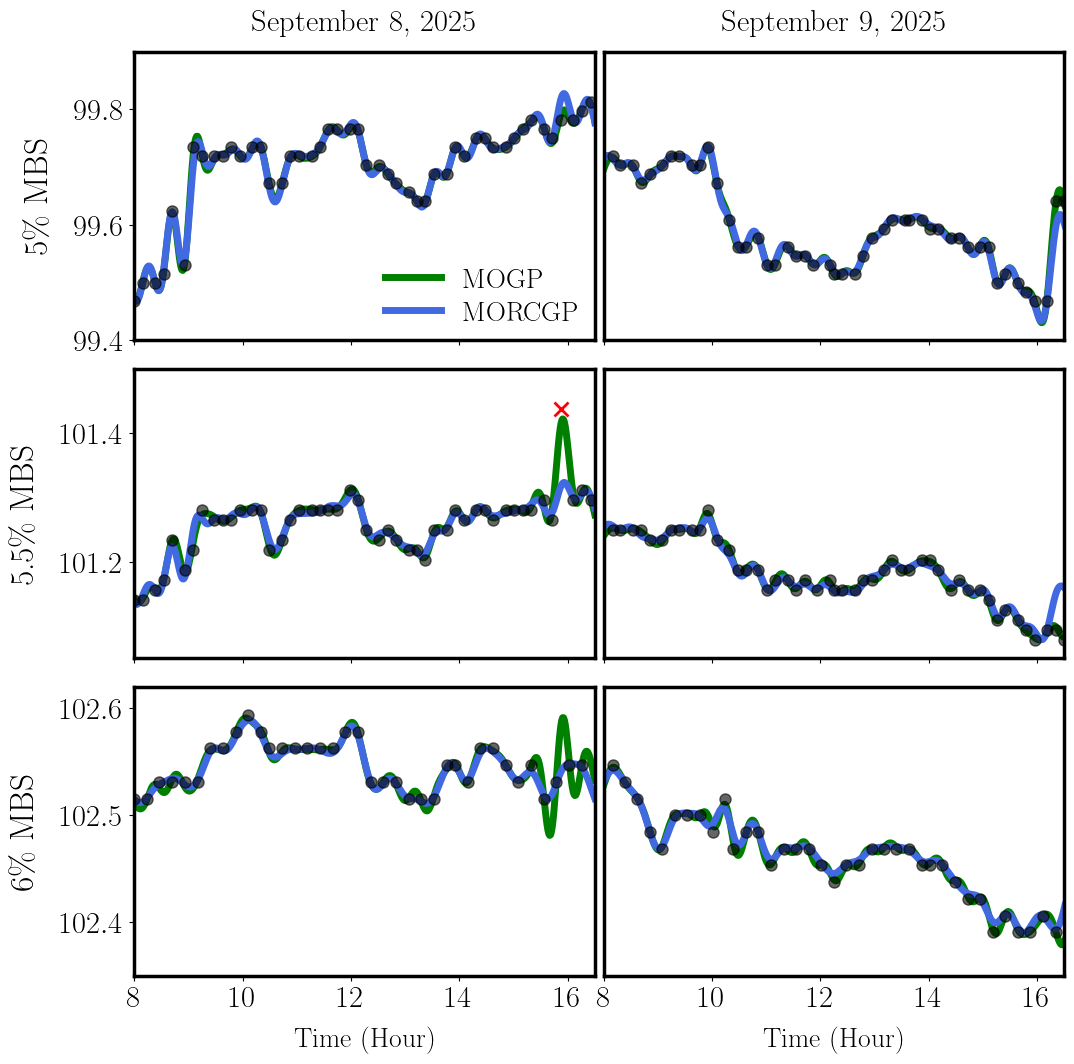

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

x_flat = x.flatten()
fig, axes = plt.subplots(
    3, 2, figsize=(12, 12),
    gridspec_kw={'wspace': 0.02, 'hspace': 0.1}
)

# X-limits for each subplot
x_limits = [
    [x_flat.min(), 545], [1430, x_flat.max()],
    [x_flat.min(), 545], [1430, x_flat.max()],
    [x_flat.min(), 545], [1430, x_flat.max()]
]

# Tick labels (same for all)
tick_labels = ['8', '10', '12', '14', '16']
tick_positions_fraction = np.linspace(0, 16/17, len(tick_labels))

# Compute common y-limits per row
y_limits_rows = [
    [99.4, 99.9],  # Row 0
    [101.05, 101.5],  # Row 1
    [102.35, 102.62]   # Row 2
]

y_titles = [r'5\% MBS', r'5.5\% MBS', r'6\% MBS']

def plot_subplot(ax, idx):
    x_start, x_end = x_limits[idx]
    tick_positions = x_start + tick_positions_fraction * (x_end - x_start)

    col_idx = idx // 2
    if col_idx == 1 and idx % 2 == 0:
        mask = np.arange(len(x_flat)) != 61
        ax.plot(x_flat[mask], Y[mask, col_idx], 'o', alpha=0.6, color='black', zorder=10)
        ax.plot(x_flat[61], Y[61, col_idx], 'x', color='red', markersize=10, mew=2)
    else:
        ax.plot(x_flat, Y[:, col_idx], 'o', alpha=0.6, color='black', zorder=10)

    ax.plot(x_tester_rescaled, test_mogp_rescaled[:, col_idx], '-', color='Green', linewidth=5)
    ax.plot(x_tester_rescaled, test_morcgp_rescaled[:, col_idx], '-', color='RoyalBlue', linewidth=5)

    if idx >= 4:
        ax.set_xlabel('Time (Hour)', fontsize=20, labelpad=10)
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
    else:
        ax.set_xlabel('')
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([])

    row = idx // 2
    ax.set_ylim(y_limits_rows[row])
    ax.set_xlim(x_limits[idx])

    if idx % 2 == 0:  # left column
        ax.set_ylabel(y_titles[row], fontsize=24, labelpad=15)
    else:
        ax.set_yticklabels([])
        ax.yaxis.set_ticks([])

    # Thicker borders
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

for i in range(6):
    row, col = divmod(i, 2)  # 3x2 layout
    plot_subplot(axes[row, col], i)

column_titles = ['September 8, 2025', 'September 9, 2025']

for col in range(2):
    axes[0, col].set_title(column_titles[col], fontsize=22, pad=15)

mogp_line = mlines.Line2D([], [], color='Green', label='MOGP')
morcp_line = mlines.Line2D([], [], color='RoyalBlue', label='MORCGP')
axes[0, 0].legend(
    handles=[mogp_line, morcp_line],
    loc='lower right',
    fontsize=20,
    frameon=False,
    handlelength=2,
    handleheight=1,
    labelspacing=0.2,
    borderpad=0.01
)

plt.show()

# fig.savefig("./FNCL_2days.pdf", format='pdf', bbox_inches='tight')